# CNN analysis of pooling indexes
This analyzes is dependent on what is defined within the network class. Meaning what area of the input is extracted is defined within the network class. This is suboptimal, but works for now. Dont exectute code cells that you are not trying to alter


### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, TcrDataset, setup_seed
from cdr_network import CdrCNN
import pandas as pd

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
def reverse_one_hot(arr):
    mapping = dict(zip(range(20), "ACDEFGHIKLMNPQRSTVWY"))
    seq = ""
    for j in range(arr.shape[1]):
        pos = arr[:, j]
        if not np.all(pos==0):
                seq += mapping[np.argmax(pos)]
    return seq

### General parameters

In [3]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_cdrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]
model_name = "cdr_model.pt"
model_path = "stored_models/"

batch_size = 64
seed= 42

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [4]:
# Peptide + All CDRS
idx = np.arange(179,248)

# Sequence
local_features = np.arange(20)
global_features = None
use_global_features = False

## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [5]:
test_data = TcrDataset(data_files[4], label_files[4])
test_one_hot = TcrDataset(data_files[4], label_files[4])

# slicing sequence dimension
test_one_hot.slice_sequences(idx)
test_data.slice_sequences(idx)
test_data.to_blossum()

test_dl = DataLoader(test_data, batch_size)


## Define the network

In [6]:
# Layer parameters
cnn_channels = 20
hidden_neurons = 64
dropout = 0.4
cnn_kernel = 3

loss_weight = len(test_data) / sum(test_data.labels)
criterion = nn.BCELoss(reduction='none')

net = CdrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
net.load_state_dict(torch.load(model_path + model_name))
net.to(device)
initial_net = CdrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
initial_net.to(device)

test_runner = Runner(test_dl, net, criterion, loss_weight, device)

Also load data as only one observed peptide. Meaning that there will only be 16 observations. This is to avoid having the GIL peptide overshadow what positions are important for the general peptide population. The reason can be seen by the peptide counts shown below.

In [7]:
peptides = test_one_hot.data[:, :20, :9]
peptides = np.array([reverse_one_hot(peptides[i]) for i in range(len(peptides))])
peptide_counts = np.unique(peptides, return_counts=True)
peptide_counts

(array(['CLGGLLTMV', 'FLYALALLL', 'GILGFVFTL', 'GLCTLVAML', 'IMDQVPFSV',
        'KLQCVDLHV', 'KTWGQYWQV', 'KVLEYVIKV', 'LLFGYPVYV', 'MLDLQPETT',
        'NLVPMVATV', 'RMFPNAPYL', 'RTLNAWVKV', 'SLFNTVATL', 'SLLMWITQV',
        'YLLEMLWRL'], dtype='<U9'),
 array([  2,  22, 686, 239,   6,   2,  15,   6,  37,   7, 136,   9,  18,
          5,  10,   7]))

In [8]:
peptide_indexes = [np.where(peptides == peptide)[0][0] for peptide in peptide_counts[0]]
unique_pep_data = test_runner.loader.dataset.data[peptide_indexes]
unique_pep_labels = test_runner.loader.dataset.labels[peptide_indexes]
unique_dataset = [[data[0], data[1]] for data in zip(unique_pep_data, unique_pep_labels)]
unique_dl = DataLoader(unique_dataset, batch_size=batch_size)
unique_runner = Runner(unique_dl, net, criterion, loss_weight, device)

## Analysis of Max pooling indexes
The hyptothesis here is based on how the CNN and maxpooling would interact. The hope is that one filter learns specific things, that are important for each position in the peptide/cdrs. By looking at the max pooling indexes we can see what position contributes with information in the dense layer. 

I need to know the amount of peptides in each group since there is big imbalance, and since we are only looking at peptide first. All identical peptides would pool in the same manner.

### Unique peptide analysis
Count the number of times each position is selected when doing maxpooling. Done for only unique peptides here

In [9]:
pool_out, idxs = unique_runner.get_pool_idxs("pep")
unique_runner.model = initial_net
pool_out_init, idxs_init = unique_runner.get_pool_idxs("pep")
unique_runner.model = net
len(unique_dataset)

16

In [10]:
total_counts = np.zeros((11))
start_pos = np.zeros((11))
for i, filter in enumerate(idxs):
    positions, counts = torch.unique(filter, return_counts=True)
    for pos, count in zip(positions, counts):
        total_counts[pos] += count
        total_counts[pos+1] += count
        total_counts[pos+2] += count
        start_pos[pos] += count

total_counts_init = np.zeros((11))
start_pos_init = np.zeros((11))
for i, filter in enumerate(idxs_init):
    positions, counts = torch.unique(filter, return_counts=True)
    for pos, count in zip(positions, counts):
        total_counts_init[pos] += count
        total_counts_init[pos+1] += count
        total_counts_init[pos+2] += count
        start_pos_init[pos] += count

Total number of counts is $ n_{filters} \cdot n_{obs} \cdot kernelSize $ ($3 \cdot 16 \cdot 3 = 144$)

Doing the same analysis on a completely new network might show a different distribution of chosen positions

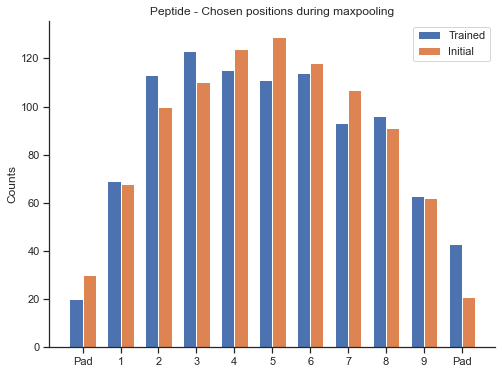

In [11]:
labels = ["Pad", "1", "2", "3", "4", "5", "6", "7", "8", "9", "Pad"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, total_counts, width, label='Trained')
rects2 = ax.bar(x + width/2, total_counts_init, width, label='Initial')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Peptide - Chosen positions during maxpooling')
ax.set_xticks(x, labels)
ax.legend()

Keep in mind that more filters are overlapping with the middle positions, than the outlier positions. When looking at the possible filter positions that are possible.

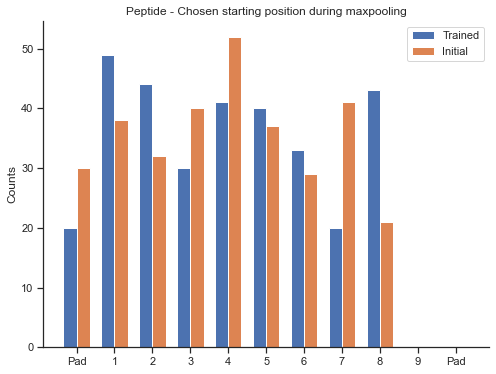

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

rects1 = ax.bar(x - width/2, start_pos, width, label='Trained')
rects2 = ax.bar(x + width/2, start_pos_init, width, label='Initial')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Peptide - Chosen starting position during maxpooling')
ax.set_xticks(x, labels)
ax.legend()


The peptide cannot start with position 9 Since the kernel will only be 9 long. The filter starting at first pad and 8 cannot be chosen either, since they contain padding.
### Weigh the plot by position specific scoring

## CDR3b analysis

### General analysis of 1 TCR or all summed
Count the number of times each position is selected when doing maxpooling. Done for all peptides here.

In [13]:
pool_out, idxs = test_runner.get_pool_idxs("cdr3b")
test_runner.model = initial_net
pool_out_init, idxs_init = test_runner.get_pool_idxs("cdr3b")
test_runner.model = net

Plot showing maxpooling positions for a specific cdr3b summed over all filters

In [14]:
total_counts = np.zeros((idxs.shape[1],19))
start_pos = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for idx in idxs[:, i]:
        start_pos[i, idx] += 1
        total_counts[i, idx] += 1
        total_counts[i, idx+1] += 1
        total_counts[i, idx+2] += 1

total_counts_init = np.zeros((idxs.shape[1],19))
start_pos_init = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        start_pos_init[i, idx] += 1
        total_counts_init[i, idx] += 1
        total_counts_init[i, idx+1] += 1
        total_counts_init[i, idx+2] += 1


### Plot showing where filters are selected for a single observation
First we do a plot Showing both the starting position and all positions that are hit for a single position just to get a feeling for the data

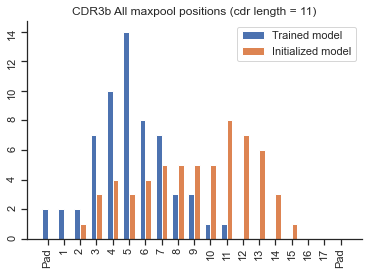

Text(0.5, 1.0, 'CDR3b Maxpool pos initial model (cdr length = 11)')

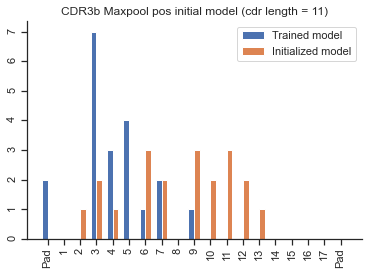

In [15]:
obs = 0 # Change here for altering observation
cdr_len = len(reverse_one_hot(test_one_hot.data[obs, :20, 24:39]))

# Plot variables
labels = ["Pad"]+[str(x) for x in range(1,18)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Actual plotting
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_counts[obs,:], width, label='Trained model')
rects2 = ax.bar(x + width/2, total_counts_init[obs,:], width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3b All maxpool positions (cdr length = {cdr_len})")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, start_pos[obs,:], width, label='Trained model')
rects2 = ax.bar(x + width/2, start_pos_init[obs,:], width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3b Maxpool pos initial model (cdr length = {cdr_len})")

### Plot summed over all observations and filters CDR3b
To get a feeling for the general data we can also look at the entire collection of maxpooled positions

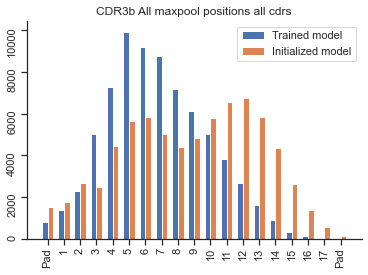

Text(0.5, 1.0, 'CDR3b Maxpool pos initial model all cdrs')

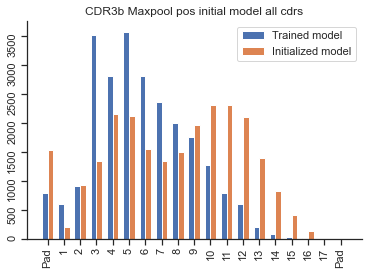

In [16]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3b All maxpool positions all cdrs")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3b Maxpool pos initial model all cdrs")

### CDR3b per peptide motif for maxpooling
Many motifs might be captured when summing over all observations. To investigate only a single peptide with a positive interaction for finding positions that are important for binding that peptide

In [42]:
cdr3b_filter = dict()
for i, obs in enumerate(test_data):
    pep = reverse_one_hot(obs[0][:20,:9])
    cdr_b = reverse_one_hot(obs[0][:20,52:])
    if obs[1] == 1:
        if pep not in cdr3b_filter:
            cdr3b_filter[pep] = {len(cdr_b) : [i]}
        elif len(cdr_b) not in cdr3b_filter[pep]:
            cdr3b_filter[pep][len(cdr_b)] = [i]
        else:
            cdr3b_filter[pep][len(cdr_b)].append(i)

Select peptide and cdr3 length from the list below

In [43]:
# 'GILGFVFTL', 'GLCTLVAML', 'NLVPMVATV', 'LLFGYPVYV', 'FLYALALLL',
# 'RTLNAWVKV', 'KTWGQYWQV', 'SLLMWITQV', 'RMFPNAPYL', 'YLLEMLWRL',
# 'MLDLQPETT', 'KVLEYVIKV', 'IMDQVPFSV', 'SLFNTVATL', 'KLQCVDLHV',
# 'CLGGLLTMV'
peptide = "GILGFVFTL"
length = 12

[print(lnth, len(cdr3b_filter[peptide][lnth])) for lnth in cdr3b_filter[peptide]]
idxs = cdr3b_filter[peptide][length]
test_data.subset_datapoints(idxs)

12 59
14 6
13 3
15 4
10 2
17 2
16 2


In [44]:
subset_ldr = DataLoader(test_data, batch_size=batch_size)
subset_runner = Runner(subset_ldr, net, criterion, loss_weight, device)

pool_out, idxs = subset_runner.get_pool_idxs("cdr3b")
subset_runner.model = initial_net
pool_out_init, idxs_init = subset_runner.get_pool_idxs("cdr3b")
subset_runner.model = net

In [45]:
total_counts = np.zeros((idxs.shape[1],19))
start_pos = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for idx in idxs[:, i]:
        start_pos[i, idx] += 1
        total_counts[i, idx] += 1
        total_counts[i, idx+1] += 1
        total_counts[i, idx+2] += 1

total_counts_init = np.zeros((idxs.shape[1],19))
start_pos_init = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        start_pos_init[i, idx] += 1
        total_counts_init[i, idx] += 1
        total_counts_init[i, idx+1] += 1
        total_counts_init[i, idx+2] += 1


### Plot of maxpooling positions for a specific length of cdr3b with a specific peptide

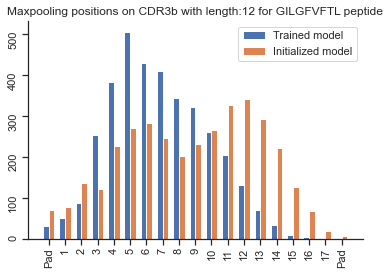

Text(0.5, 1.0, 'Maxpooling filter start on CDR3b with length:12 for GILGFVFTL peptide')

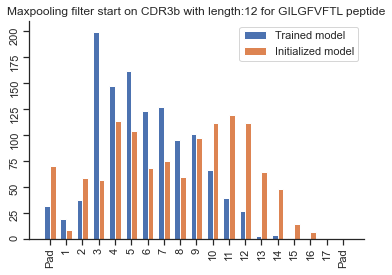

In [46]:
labels = ["Pad"]+[str(x) for x in range(1,18)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3b with length:{length} for {peptide} peptide")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling filter start on CDR3b with length:{length} for {peptide} peptide")

Filters can store the important information in all 3 positions, but they are note necessarily equally important. To handle this issue the standard deviation is calculated for each position in each filter and added instead of the count. The standard deviation shows how specific a motif has to bee to be captured. Since important positions will have high weights for some residues, while low for others giving a high standard deviation. Compared with a motif with no preference this will have lower standard devation

In [47]:
cdr3b_weights = test_runner.model.cdr3b_conv.weight.detach().numpy()
pos_weight = np.std(cdr3b_weights,1) #axis 1 is in channels (peptide encoding)

cdr3b_weights_init = initial_net.cdr3b_conv.weight.detach().numpy()
pos_weight_init = np.std(cdr3b_weights_init,1)

In [48]:
total_counts = np.zeros((idxs.shape[1],19))
start_pos = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):  #observations
    for j, idx in enumerate(idxs[:, i]):    #filters
        total_counts[i, idx] += pos_weight[j, 0]
        total_counts[i, idx+1] += pos_weight[j, 1]
        total_counts[i, idx+2] += pos_weight[j, 2]

total_counts_init = np.zeros((idxs.shape[1],19))
start_pos_init = np.zeros((idxs.shape[1],19))
for i in range(idxs_init.shape[1]):
    for j, idx in enumerate(idxs_init[:, i]):
        total_counts_init[i, idx] += pos_weight_init[j, 0]
        total_counts_init[i, idx+1] += pos_weight_init[j, 1]
        total_counts_init[i, idx+2] += pos_weight_init[j, 2]

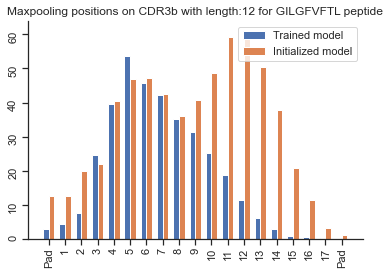

In [49]:
labels = ["Pad"]+[str(x) for x in range(1,18)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3b with length:{length} for {peptide} peptide")
plt.show()

Lastly you can also add information about the activation of the layer. Higher activation should be due to a more significant motif.

In [50]:
total_counts = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for j, idx in enumerate(idxs[:, i]):
        total_counts[i, idx] += pos_weight[j, 0] * pool_out[i, j]
        total_counts[i, idx+1] += pos_weight[j, 1] * pool_out[i, j]
        total_counts[i, idx+2] += pos_weight[j, 2] * pool_out[i, j]

total_counts_init = np.zeros((idxs.shape[1],19))
start_pos_init = np.zeros((idxs.shape[1],19))
for i in range(idxs_init.shape[1]):
    for j, idx in enumerate(idxs_init[:, i]):
        total_counts_init[i, idx] += pos_weight_init[j, 0] * pool_out_init[i, j]
        total_counts_init[i, idx+1] += pos_weight_init[j, 1] * pool_out_init[i, j]
        total_counts_init[i, idx+2] += pos_weight_init[j, 2] * pool_out_init[i, j]

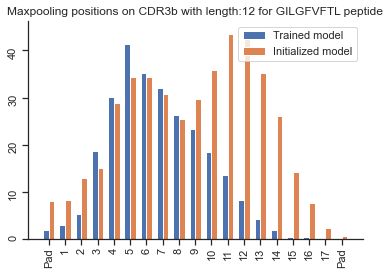

In [51]:
labels = ["Pad"]+[str(x) for x in range(1,18)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3b with length:{length} for {peptide} peptide")
plt.show()


## CDR3a analysis

In [52]:
pool_out, idxs = test_runner.get_pool_idxs("cdr3a")
test_runner.model = initial_net
pool_out_init, idxs_init = test_runner.get_pool_idxs("cdr3a")
test_runner.model = net

### Plot showing all the maxpoolin filters for a specific observation
First see a single observation to get a feel for it

In [53]:
total_counts = np.zeros((idxs.shape[1],17))
start_pos = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs[:, i]:
        start_pos[i, idx] += 1
        total_counts[i, idx] += 1
        total_counts[i, idx+1] += 1
        total_counts[i, idx+2] += 1

total_counts_init = np.zeros((idxs.shape[1],17))
start_pos_init = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        start_pos_init[i, idx] += 1
        total_counts_init[i, idx] += 1
        total_counts_init[i, idx+1] += 1
        total_counts_init[i, idx+2] += 1


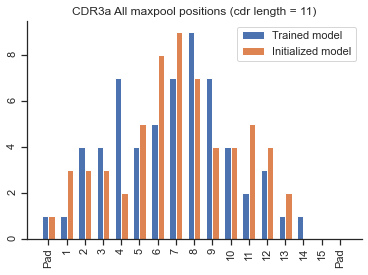

Text(0.5, 1.0, 'CDR3a Maxpool pos initial model (cdr length = 11)')

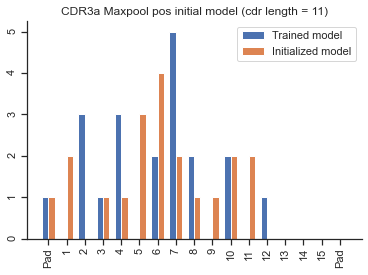

In [54]:
labels = ["Pad"]+[str(x) for x in range(1,16)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

obs = 0 # Change here for altering observation
cdr_len = len(reverse_one_hot(test_one_hot.data[obs, :20, 24:39]))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_counts[obs,:], width, label='Trained model')
rects2 = ax.bar(x + width/2, total_counts_init[obs,:], width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3a All maxpool positions (cdr length = {cdr_len})")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, start_pos[obs,:], width, label='Trained model')
rects2 = ax.bar(x + width/2, start_pos_init[obs,:], width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3a Maxpool pos initial model (cdr length = {cdr_len})")

### Plot showing for all filters and all positions

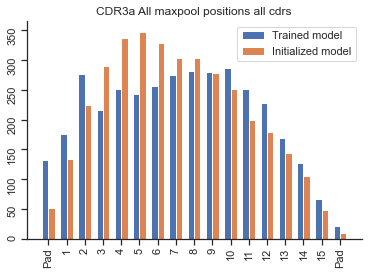

Text(0.5, 1.0, 'CDR3a Maxpool pos initial model all cdrs')

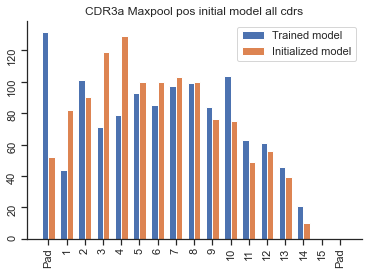

In [55]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3a All maxpool positions all cdrs")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3a Maxpool pos initial model all cdrs")

## CDR3a per peptide analysis
Only look at TCRs with known positive binding to specific peptides

In [56]:
cdr3a_filter = dict()
test_data.subset_datapoints(np.arange(1207))
for i, obs in enumerate(test_data):
    pep = reverse_one_hot(obs[0][:20,:9])
    cdr_a = reverse_one_hot(obs[0][:20,24:39])
    if obs[1] == 1:
        if pep not in cdr3a_filter:
            cdr3a_filter[pep] = {len(cdr_a) : [i]}
        elif len(cdr_a) not in cdr3a_filter[pep]:
            cdr3a_filter[pep][len(cdr_a)] = [i]
        else:
            cdr3a_filter[pep][len(cdr_a)].append(i)

In [57]:
length = 14
[print(lnth, len(cdr3a_filter[peptide][lnth])) for lnth in cdr3a_filter[peptide]]
idxs = cdr3a_filter[peptide][length]
test_data.subset_datapoints(idxs)
print("Number of observations:", len(test_data))

11 40
14 78
13 37
15 13
9 1
12 29
10 5
Number of observations: 78


In [58]:
pool_out, idxs = subset_runner.get_pool_idxs("cdr3a")
subset_runner.model = initial_net
pool_out_init, idxs_init = subset_runner.get_pool_idxs("cdr3a")
subset_runner.model = net

In [59]:
total_counts = np.zeros((idxs.shape[1],17))
start_pos = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs[:, i]:
        start_pos[i, idx] += 1
        total_counts[i, idx] += 1
        total_counts[i, idx+1] += 1
        total_counts[i, idx+2] += 1

total_counts_init = np.zeros((idxs.shape[1],17))
start_pos_init = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        start_pos_init[i, idx] += 1
        total_counts_init[i, idx] += 1
        total_counts_init[i, idx+1] += 1
        total_counts_init[i, idx+2] += 1

### Plots showing maxpooling positions summed over all filters for cdr3a for specific peptide

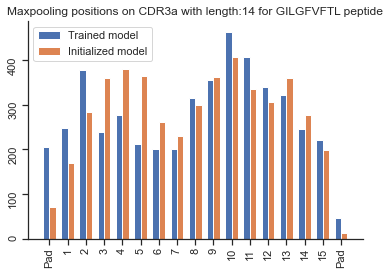

Text(0.5, 1.0, 'Maxpooling filter start on CDR3a with length:14 for GILGFVFTL peptide')

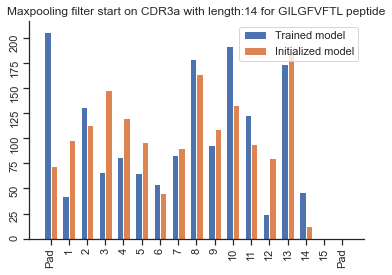

In [60]:

labels = ["Pad"]+[str(x) for x in range(1,16)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3a with length:{length} for {peptide} peptide")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling filter start on CDR3a with length:{length} for {peptide} peptide")

This can again be weighted by a position specific scoring

In [61]:
cdr3a_weights = test_runner.model.cdr3a_conv.weight.detach().numpy()
pos_weight = np.std(cdr3a_weights,1) #axis 1 is in channels (peptide encoding)

cdr3a_weights_init = initial_net.cdr3a_conv.weight.detach().numpy()
pos_weight_init = np.std(cdr3a_weights_init,1) #axis 1 is in channels (peptide encoding)

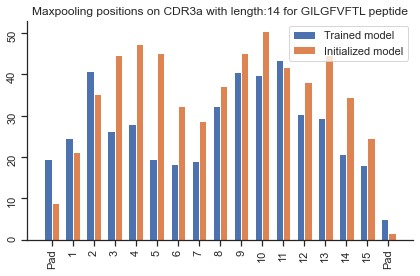

In [62]:
total_counts = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for j, idx in enumerate(idxs[:, i]):
        total_counts[i, idx] += pos_weight[j, 0]
        total_counts[i, idx+1] += pos_weight[j, 1]
        total_counts[i, idx+2] += pos_weight[j, 2]

total_counts_init = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        total_counts_init[i, idx] += pos_weight_init[j, 0]
        total_counts_init[i, idx+1] += pos_weight_init[j, 0]
        total_counts_init[i, idx+2] += pos_weight_init[j, 0]

labels = ["Pad"]+[str(x) for x in range(1,16)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3a with length:{length} for {peptide} peptide")
plt.tight_layout()
plt.show()

Adding the activation output from the maxpooled sigmoid to scale how "significant" the output is

In [63]:
total_counts = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for j, idx in enumerate(idxs[:, i]):
        total_counts[i, idx] += pos_weight[j, 0] * pool_out[i, j]
        total_counts[i, idx+1] += pos_weight[j, 1] * pool_out[i, j]
        total_counts[i, idx+2] += pos_weight[j, 2]  * pool_out[i, j]

total_counts_init = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        total_counts_init[i, idx] += pos_weight_init[j, 0] * pool_out_init[i, j]
        total_counts_init[i, idx+1] += pos_weight_init[j, 0] * pool_out_init[i, j]
        total_counts_init[i, idx+2] += pos_weight_init[j, 0] * pool_out_init[i, j]

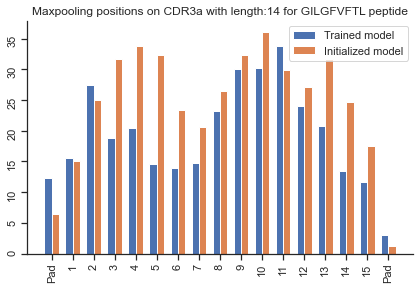

In [64]:
labels = ["Pad"]+[str(x) for x in range(1,16)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
plt.tight_layout()
ax.set_title(f"Maxpooling positions on CDR3a with length:{length} for {peptide} peptide")
plt.show()

## Check results from CV experiment to see per peptide performance

For now only has the performance of the CDRs

In [191]:
result = pd.read_csv("../../results/modelling/CdrCNN_cdr_scores.csv", index_col=0)

In [192]:
from sklearn import metrics
def calc_auc(x):
    d = {}
    d["auc"] = metrics.roc_auc_score(x["labels"],x["scores"])
    d["counts"] = len(x)
    return pd.Series(d, index=["auc", "counts"])

result = result[result["peptide"].isin(result["peptide"].value_counts(ascending=False).head(10).index)]
auc_df = result.groupby("peptide").apply(calc_auc)

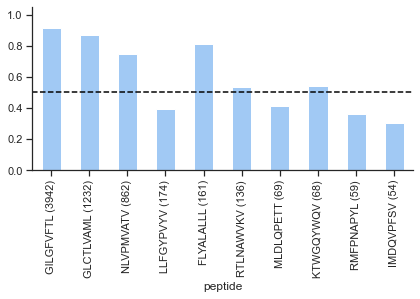

In [201]:
def get_labels(x):
    return f"{x.name} ({int(x['counts'])})"

auc_df = auc_df.sort_values("counts",ascending=False)
ax = auc_df.plot.bar(y="auc",ylim=[0,1.05])
ax.axhline(0.5, ls="--", c="black")
plt.tight_layout()
ax.get_legend().remove()
ax.set_xticklabels(auc_df.apply(get_labels, axis=1))
plt.savefig("../../results/modelling/cdr_peptide_auc.png")